**Group Details**

1.   **Name**: Sohom Mukherjee, **Student Number**: 7010515, **Email**: somu00003@stud.uni-saarland.de
2.   **Name**: Shayari Bhattacharjee, **Student Number**: 7009998, **Email**: shbh00002@stud.uni-saarland.de

# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar

In [2]:
!pip install scipy==1.1.0

### 1.1 Loading the dataset

In [1]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob

import PIL
from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms
import logging

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import math

class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode

        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                # add more trasnformations as you see fit
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture (2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [2]:
# Base Model

class BaseModel(nn.Module):
    """We utilise the base model to initialize weights for ENet model"""
    def __init__(self):
        super(BaseModel, self).__init__()
        self.logger = logging.getLogger(self.__class__.__name__)

    def forward(self):
        raise NotImplementedError

    def summary(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        nbr_params = sum([np.prod(p.size()) for p in model_parameters])
        self.logger.info(f'Nbr of trainable parameters: {nbr_params}')

    def __str__(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        nbr_params = sum([np.prod(p.size()) for p in model_parameters])
        return super(BaseModel, self).__str__() + f'\nNbr of trainable parameters: {nbr_params}'
        #return summary(self, input_shape=(2, 3, 224, 224))

def dir_exists(path):
    if not os.path.exists(path):
            os.makedirs(path)

def initialize_weights(*models):
    for model in models:
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1.)
                m.bias.data.fill_(1e-4)
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, 0.0001)
                m.bias.data.zero_()

In [3]:
# ENet Model 

class InitalBlock(nn.Module):
    """This class defines the initial bottleneck for ENet architecture"""
    def __init__(self, in_channels, use_prelu=True):
        super(InitalBlock, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.conv = nn.Conv2d(in_channels, 16 - in_channels, 3, padding=1, stride=2)
        self.bn = nn.BatchNorm2d(16)
        self.prelu = nn.PReLU(16) if use_prelu else nn.ReLU(inplace=True)

    def forward(self, x):   
        x = torch.cat((self.pool(x), self.conv(x)), dim=1)
        x = self.bn(x)
        x = self.prelu(x)
        return x

class BottleNeck(nn.Module):
    """This class defines the various bottlenecks for upsampling, downsampling, and convolution"""
    def __init__(self, in_channels, out_channels=None, activation=None, dilation=1, downsample=False, proj_ratio=4, 
                        upsample=False, asymetric=False, regularize=True, p_drop=None, use_prelu=True):
        super(BottleNeck, self).__init__()

        self.pad = 0
        self.upsample = upsample
        self.downsample = downsample
        if out_channels is None: out_channels = in_channels
        else: self.pad = out_channels - in_channels

        if regularize: assert p_drop is not None
        if downsample: assert not upsample
        elif upsample: assert not downsample
        inter_channels = in_channels//proj_ratio

        # Main
        if upsample:
            self.spatil_conv = nn.Conv2d(in_channels, out_channels, 1, bias=False)
            self.bn_up = nn.BatchNorm2d(out_channels)
            self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        elif downsample:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # Bottleneck
        if downsample: 
            self.conv1 = nn.Conv2d(in_channels, inter_channels, 2, stride=2, bias=False)
        else:
            self.conv1 = nn.Conv2d(in_channels, inter_channels, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(inter_channels)
        self.prelu1 = nn.PReLU() if use_prelu else nn.ReLU(inplace=True)

        if asymetric:
            self.conv2 = nn.Sequential(
                nn.Conv2d(inter_channels, inter_channels, kernel_size=(1,5), padding=(0,2)),
                nn.BatchNorm2d(inter_channels),
                nn.PReLU() if use_prelu else nn.ReLU(inplace=True),
                nn.Conv2d(inter_channels, inter_channels, kernel_size=(5,1), padding=(2,0)),
            )
        elif upsample:
            self.conv2 = nn.ConvTranspose2d(inter_channels, inter_channels, kernel_size=3, padding=1,
                                            output_padding=1, stride=2, bias=False)
        else:
            self.conv2 = nn.Conv2d(inter_channels, inter_channels, 3, padding=dilation, dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_channels)
        self.prelu2 = nn.PReLU() if use_prelu else nn.ReLU(inplace=True)

        self.conv3 = nn.Conv2d(inter_channels, out_channels, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.prelu3 = nn.PReLU() if use_prelu else nn.ReLU(inplace=True)

        self.regularizer = nn.Dropout2d(p_drop) if regularize else None
        self.prelu_out = nn.PReLU() if use_prelu else nn.ReLU(inplace=True)

    def forward(self, x, indices=None, output_size=None):
        # Main branch
        identity = x
        if self.upsample:
            assert (indices is not None) and (output_size is not None)
            identity = self.bn_up(self.spatil_conv(identity))
            if identity.size() != indices.size():
                pad = (indices.size(3) - identity.size(3), 0, indices.size(2) - identity.size(2), 0)
                identity = F.pad(identity, pad, "constant", 0)
            identity = self.unpool(identity, indices=indices)#, output_size=output_size)
        elif self.downsample:
            identity, idx = self.pool(identity)

        if self.pad > 0:
            extras = torch.zeros((identity.size(0), self.pad, identity.size(2), identity.size(3)))
            if torch.cuda.is_available(): extras = extras.cuda(0)
            identity = torch.cat((identity, extras), dim = 1)

        # Bottleneck
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.prelu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.prelu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.prelu3(x)
        if self.regularizer is not None:
            x = self.regularizer(x)

        # When the input dim is odd, we might have a mismatch of one pixel
        if identity.size() != x.size():
            pad = (identity.size(3) - x.size(3), 0, identity.size(2) - x.size(2), 0)
            x = F.pad(x, pad, "constant", 0)

        x += identity
        x = self.prelu_out(x)

        if self.downsample:
            return x, idx
        return x

class ENet(BaseModel):
    """This class defines the various stages of ENet architecture"""
    def __init__(self, num_classes, in_channels=3, freeze_bn=False, **_):
        super(ENet, self).__init__()
        self.initial = InitalBlock(in_channels)

        # Stage 1
        self.bottleneck10 = BottleNeck(16, 64, downsample=True, p_drop=0.01)
        self.bottleneck11 = BottleNeck(64, p_drop=0.01)
        self.bottleneck12 = BottleNeck(64, p_drop=0.01)
        self.bottleneck13 = BottleNeck(64, p_drop=0.01)
        self.bottleneck14 = BottleNeck(64, p_drop=0.01)

        # Stage 2
        self.bottleneck20 = BottleNeck(64, 128, downsample=True, p_drop=0.1)
        self.bottleneck21 = BottleNeck(128, p_drop=0.1)
        self.bottleneck22 = BottleNeck(128, dilation=2, p_drop=0.1)
        self.bottleneck23 = BottleNeck(128, asymetric=True, p_drop=0.1)
        self.bottleneck24 = BottleNeck(128, dilation=4, p_drop=0.1)
        self.bottleneck25 = BottleNeck(128, p_drop=0.1)
        self.bottleneck26 = BottleNeck(128, dilation=8, p_drop=0.1)
        self.bottleneck27 = BottleNeck(128, asymetric=True, p_drop=0.1)
        self.bottleneck28 = BottleNeck(128, dilation=16, p_drop=0.1)
    
        # Stage 3
        self.bottleneck31 = BottleNeck(128, p_drop=0.1)
        self.bottleneck32 = BottleNeck(128, dilation=2, p_drop=0.1)
        self.bottleneck33 = BottleNeck(128, asymetric=True, p_drop=0.1)
        self.bottleneck34 = BottleNeck(128, dilation=4, p_drop=0.1)
        self.bottleneck35 = BottleNeck(128, p_drop=0.1)
        self.bottleneck36 = BottleNeck(128, dilation=8, p_drop=0.1)
        self.bottleneck37 = BottleNeck(128, asymetric=True, p_drop=0.1)
        self.bottleneck38 = BottleNeck(128, dilation=16, p_drop=0.1)

        # Stage 4
        self.bottleneck40 = BottleNeck(128, 64, upsample=True, p_drop=0.1, use_prelu=False)
        self.bottleneck41 = BottleNeck(64, p_drop=0.1, use_prelu=False)
        self.bottleneck42 = BottleNeck(64, p_drop=0.1, use_prelu=False)

        # Stage 5
        self.bottleneck50 = BottleNeck(64, 16, upsample=True, p_drop=0.1, use_prelu=False)
        self.bottleneck51 = BottleNeck(16, p_drop=0.1, use_prelu=False)

        # Stage 6
        self.fullconv = nn.ConvTranspose2d(16, num_classes, kernel_size=3, padding=1,
                                            output_padding=1, stride=2, bias=False)
        initialize_weights(self)
        if freeze_bn: self.freeze_bn()

    def forward(self, x):
        x = self.initial(x)

        # Stage 1
        sz1 = x.size()
        x, indices1 = self.bottleneck10(x)
        x = self.bottleneck11(x)
        x = self.bottleneck12(x)
        x = self.bottleneck13(x)
        x = self.bottleneck14(x)

        # Stage 2
        sz2 = x.size()
        x, indices2 = self.bottleneck20(x)
        x = self.bottleneck21(x)
        x = self.bottleneck22(x)
        x = self.bottleneck23(x)
        x = self.bottleneck24(x)
        x = self.bottleneck25(x)
        x = self.bottleneck26(x)
        x = self.bottleneck27(x)
        x = self.bottleneck28(x)

        # Stage 3
        x = self.bottleneck31(x)
        x = self.bottleneck32(x)
        x = self.bottleneck33(x)
        x = self.bottleneck34(x)
        x = self.bottleneck35(x)
        x = self.bottleneck36(x)
        x = self.bottleneck37(x)
        x = self.bottleneck38(x)

        # Stage 4
        x = self.bottleneck40(x, indices=indices2, output_size=sz2)
        x = self.bottleneck41(x)
        x = self.bottleneck42(x)

        # Stage 5
        x = self.bottleneck50(x, indices=indices1, output_size=sz1)
        x = self.bottleneck51(x)

        # Stage 6
        x = self.fullconv(x)
        return x 

    def get_backbone_params(self):
        # There is no backbone for unet, all the parameters are trained from scratch
        return []

    def get_decoder_params(self):
        return self.parameters()

    def freeze_bn(self):
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d): module.eval()

In [4]:
# Creating an instance of the model defined above. 
# You can modify it incase you need to pass paratemers to the constructor.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ENet(num_classes=21).to(device)
print(model)

ENet(
  (initial): InitalBlock(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=16)
  )
  (bottleneck10): BottleNeck(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(16, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu1): PReLU(num_parameters=1)
    (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu2): PReLU(num_parameters=1)
    (conv3): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

### 1.3 Hyperparameters (0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [5]:
local_path = './VOCdevkit/VOC2012/' # modify it according to your device
learning_rate = 0.0001
epochs = 100 # number of training epochs
bs = 9 # batch size 
nw = 0 # num workers

# optimizer hyperparameters
weight_decay = 5*1e-4
momentum = 0.9

### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [6]:
# Train Loader

# dataset variable
train_dataset = pascalVOCDataset(
    root=local_path,
    split="train",
    is_transform=True)

# dataloader variable
trainloader = data.DataLoader(
        train_dataset,
        batch_size=bs,
        num_workers=nw,
        shuffle=True,
    )

print("Number of Training Iterations per Epoch:", len(trainloader))

Number of Training Iterations per Epoch: 163


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([9, 3, 512, 512])
torch.Size([9, 512, 512])


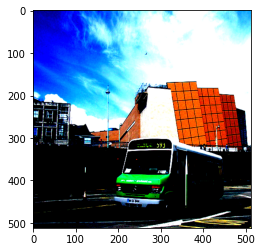

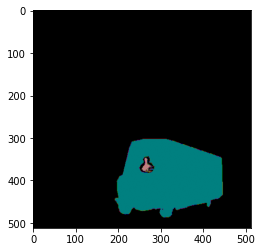

In [7]:
# Visualize Training Images and Labels

dataiter = iter(trainloader)
# get first batch of the dataset
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

def imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

# show one image
imshow(images[0])

# show label map
decoded = train_dataset.decode_segmap(labels[0].cpu().numpy(), True)

In [8]:
# Val Loader

# dataset variable
val_dataset = pascalVOCDataset(
    root=local_path,
    split="val",
    is_transform=True)

# dataloader variable
valloader = data.DataLoader(
        val_dataset,
        batch_size=bs,
        num_workers=nw,
        shuffle=True,
    )

print("Number of Validation Iterations per Epoch:", len(valloader))

Number of Validation Iterations per Epoch: 161


### 1.5 Loss fuction and Optimizer (1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [9]:
# loss function
loss_f = nn.CrossEntropyLoss()

# optimizer variable
opt = torch.optim.SGD(model.parameters(), weight_decay=weight_decay, lr=learning_rate, momentum=momentum)

### 1.6 Training the model (3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix
import sklearn as sk


class custom_conf_matrix():
    def __init__(self, lbl,n_class):
        self.lbl = lbl
        self.n_class = n_class
        self.conf_mat = np.zeros((self.n_class, self.n_class))

    def update_step(self, truth_lbl, pred_lbl):
        if (truth_lbl == 255).all():
            return
        curr_conf_mat = confusion_matrix(y_true=truth_lbl,
                                         y_pred=pred_lbl,
                                         labels=self.lbl)
        self.conf_mat += curr_conf_mat

    
    def evaluate(self):
        intersection = np.diag(self.conf_mat)
        ground_truth_set = self.conf_mat.sum(axis=1)
        predicted_set = self.conf_mat.sum(axis=0)
        union =  ground_truth_set + predicted_set - intersection
        mean_iou = np.mean(intersection / union.astype(np.float32))
        
        TP = np.diag(self.conf_mat)
        FP = self.conf_mat.sum(axis=0) - TP
        FN = self.conf_mat.sum(axis=1) - TP
        TN = self.conf_mat.sum() - (FP + FN + TP)
        f1_score = TP/(TP + 0.5*(FP+FN))
        mean_f1 = np.mean(f1_score)
        dice = 2*TP/ (2*TP+ FP + FN)
        mean_dice = np.mean(dice)
        
        return mean_iou, mean_f1, mean_dice
    
    def reset(self):
        self.conf_mat = np.zeros((self.n_class, self.n_class))

In [11]:
def train():
    epoch = 0
    total_epochs = epochs 
    train_step = 5
    val_step = 10
    val_epoch = 0
    
    train_losses = {}
    
    
    val_losses = {}
    val_ious = {}
    val_fons = {}
    val_dics = {}
    
    iou_interval = val_step

    while(epoch < total_epochs):
        epoch_loss = 0
        for (imgs, labels) in trainloader:
            model.train()            
            imgs, labels = imgs.to(device), labels.to(device)
            opt.zero_grad()
            out = model(imgs)
            loss = loss_f(out,labels)
            loss.backward()
            opt.step()

            epoch_loss += loss.item()
            
        train_losses[epoch] = epoch_loss / len(trainloader)

        if epoch % train_step == 0:
            print("Epoch:", epoch, "Loss:", epoch_loss/len(trainloader))
            
        if epoch % val_step == 0 and epoch != 0:
            print("**Validation Step**\n")
            
            model.eval()
            conf_mat = custom_conf_matrix([i for i in range(0, 21)], 21)
            with torch.no_grad():
                val_loss = 0
                for vi, (vimg, vlbl) in enumerate(tqdm(valloader)):
                    vimg, vlbl = vimg.to(device), vlbl.to(device)
                    vout = model(vimg)
                    vloss = loss_f(vout,vlbl)
                    pred = vout.data.max(1)[1].cpu().numpy()
                    gt = vlbl.data.cpu().numpy()
                    conf_mat.update_step(gt.flatten(), pred.flatten())
                    val_loss += vloss.item()
                    
                val_losses[epoch] = val_loss/len(valloader)
                
                
                iou_score, f1_score, dice_coeff = conf_mat.evaluate()
                
                val_ious[val_epoch] = iou_score
                val_fons[val_epoch] = f1_score
                val_dics[val_epoch] = dice_coeff
                
                print("Epoch:", epoch, "Val Loss:", val_loss/len(valloader), 
                      "Mean IoU:", np.round(iou_score, 4), "F1-Score:", 
                      np.round(f1_score, 4), "Dice Coeff:", np.round(dice_coeff, 4))
                
                state = {
                    "epoch": epoch + 1,
                    "model_state": model.state_dict(),
                    "optimizer_state": opt.state_dict(),
                    "best_iou": iou_score,
                }

                save_path = os.path.join("./saved-models", "{}_epoch{}_model.pth".
                                         format("ENet_VOC", epoch))
                torch.save(state, save_path)

                conf_mat.reset()
                val_epoch += 1

        epoch += 1   

    print(train_losses, val_losses)

if __name__ == "__main__":
    train()

Epoch: 0 Loss: 3.0293468712297686
Epoch: 5 Loss: 1.7922596960711332


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch: 10 Loss: 1.4873191220628703
**Validation Step**



100%|██████████| 161/161 [04:08<00:00,  1.54s/it]


Epoch: 10 Val Loss: 1.4705588617680236 Mean IoU: 0.0354 F1-Score: 0.0406 Dice Coeff: 0.0406
Epoch: 15 Loss: 1.4062745366359781


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch: 20 Loss: 1.3715534360130872
**Validation Step**



100%|██████████| 161/161 [04:08<00:00,  1.54s/it]


Epoch: 20 Val Loss: 1.3540083925176112 Mean IoU: 0.0354 F1-Score: 0.0406 Dice Coeff: 0.0406
Epoch: 25 Loss: 1.3503141893199617


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch: 30 Loss: 1.3381723461706945
**Validation Step**



100%|██████████| 161/161 [04:03<00:00,  1.51s/it]


Epoch: 30 Val Loss: 1.3193414403785089 Mean IoU: 0.0354 F1-Score: 0.0406 Dice Coeff: 0.0406
Epoch: 35 Loss: 1.3247759795627712


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch: 40 Loss: 1.3196958299794812
**Validation Step**



100%|██████████| 161/161 [04:04<00:00,  1.52s/it]


Epoch: 40 Val Loss: 1.3018973569692291 Mean IoU: 0.0354 F1-Score: 0.0406 Dice Coeff: 0.0406
Epoch: 45 Loss: 1.309364360900013


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch: 50 Loss: 1.304203487978391
**Validation Step**



100%|██████████| 161/161 [04:07<00:00,  1.53s/it]


Epoch: 50 Val Loss: 1.2864590424188176 Mean IoU: 0.0354 F1-Score: 0.0406 Dice Coeff: 0.0406
Epoch: 55 Loss: 1.3006224880920598


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch: 60 Loss: 1.2922967131152474
**Validation Step**



100%|██████████| 161/161 [04:11<00:00,  1.56s/it]


Epoch: 60 Val Loss: 1.2746495097320272 Mean IoU: 0.0354 F1-Score: 0.0406 Dice Coeff: 0.0406
Epoch: 65 Loss: 1.2852056059369281


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch: 70 Loss: 1.2843660942615907
**Validation Step**



100%|██████████| 161/161 [04:17<00:00,  1.60s/it]


Epoch: 70 Val Loss: 1.2670538777149982 Mean IoU: 0.0354 F1-Score: 0.0406 Dice Coeff: 0.0406
Epoch: 75 Loss: 1.2773661353836763


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch: 80 Loss: 1.2741350388965724
**Validation Step**



100%|██████████| 161/161 [04:14<00:00,  1.58s/it]


Epoch: 80 Val Loss: 1.259092732986308 Mean IoU: 0.0354 F1-Score: 0.0406 Dice Coeff: 0.0406
Epoch: 85 Loss: 1.2742098076211894


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch: 90 Loss: 1.2677919012637227
**Validation Step**



100%|██████████| 161/161 [04:05<00:00,  1.53s/it]


Epoch: 90 Val Loss: 1.2519477150455025 Mean IoU: 0.0354 F1-Score: 0.0406 Dice Coeff: 0.0406
Epoch: 95 Loss: 1.2670967648365745
{0: 3.0293468712297686, 1: 2.7340523699309927, 2: 2.438672314392277, 3: 2.1603117040329916, 4: 1.9477872109851955, 5: 1.7922596960711332, 6: 1.6861814106900268, 7: 1.6149866164096294, 8: 1.5600886820284134, 9: 1.5162746035979568, 10: 1.4873191220628703, 11: 1.4603686435090983, 12: 1.4435198051066487, 13: 1.4282099436397202, 14: 1.4173850164823005, 15: 1.4062745366359781, 16: 1.4000065238929233, 17: 1.392399897970305, 18: 1.3817168075614181, 19: 1.3769771522539525, 20: 1.3715534360130872, 21: 1.3680308004098436, 22: 1.3632204726429804, 23: 1.3602903796119925, 24: 1.3567724059695847, 25: 1.3503141893199617, 26: 1.351689166086583, 27: 1.3438642120068789, 28: 1.3437849839040839, 29: 1.339988823682984, 30: 1.3381723461706945, 31: 1.3347403363216144, 32: 1.3347854222988058, 33: 1.3321276793450665, 34: 1.3265414117304093, 35: 1.3247759795627712, 36: 1.3263094757963543

### 1.7 Evaluate your model (1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [ ]:
"""
Evaluation has been performed during the training and the definition
of evaluation metrics can be found under custom_conf_matrix.evaluate()
"""

### 1.8 Plot the evaluation metrics against epochs (1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

### 1.9 Visualize results (0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

In [13]:
# dataset variable
test_dataset = pascalVOCDataset(
    root=local_path,
    is_transform=True,
    test_mode=True)

testloader = test_dataset

In [24]:
model_PATH = './esults/ENet_VOC_epoch90_model.pth'
out_path = './opt-images'

In [ ]:
def test(img):    
    n_classes = testloader.n_classes
    resized_img = m.imresize(img, (testloader.img_size[0], testloader.img_size[1]), interp="bicubic")
    orig_size = img.shape[:-1]
    img = m.imresize(img, (testloader.img_size[0], testloader.img_size[1]))
    img = img[:, :, ::-1]
    img = img.astype(np.float64)
    img -= testloader.mean

    # NHWC -> NCHW
    img = img.transpose(2, 0, 1)
    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img).float()

    # Setup Model    
    model = ENet(num_classes=21)
    
    checkpoint = torch.load(model_PATH)
    model.load_state_dict(checkpoint["model_state"])
    model.eval()
    model.to(device)

    images = img.to(device)
    outputs = model(images)
    pred = np.squeeze(outputs.data.max(1)[1].cpu().numpy(), axis=0)
    
    decoded = testloader.decode_segmap(pred)
    print("Classes found: ", np.unique(pred))
    m.imshow()
    m.imsave(, decoded)
    print("Segmentation Mask Saved at: {}".format(out_path))

In [ ]:
if __name__ == "__main__":
    images = [m.imread(file) for file in glob.glob("./test-images/*.jpg")]
    
    for img in images:
        test(img)

In [ ]:
"""
NOTE: We did not obtain desired plots for evaluations metrics as well as 
proper visualizations for output segmentation maps in this .ipynb notebook. 
So, we provide evaluation metrics and output segmentation maps using a 
different dataloader (analogous to ones we used for Tasks 2 and 3) in our 
report. The code for ENet using this data loader can be found in the git 
repository under the folder task-2-3.
""" 